In [1]:
import numpy as np
import nutopy as nt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [2]:
!python -m numpy.f2py -c gfun.f90     -m gfun     > /dev/null 2>&1
!python -m numpy.f2py -c gfun_d.f90   -m gfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c gfun_d_d.f90 -m gfun_d_d > /dev/null 2>&1

from gfun     import gfun
from gfun_d   import gfun_d
from gfun_d_d import gfun_d_d

In [3]:
!python -m numpy.f2py -c hfun.f90     hfun.pyf     -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90   hfun_d.pyf   -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 hfun_d_d.pyf -m hfun_d_d > /dev/null 2>&1

from hfun     import hfun     as hf
from hfun_d   import hfun_d   as hf_d
from hfun_d_d import hfun_d_d as hf_d_d

In [4]:
def dhfun_mano(t, x, dx, p, dp, a, b, c):
    # dh = dh_x dx + dh_p dp
    p1, p2     = p
    dp1, dp2   = dp
    
    g, dg      = gfun_d(x, dx, a, b, c)
    
    g1, g2     = g
    dg1, dg2   = dg
    
    hd = -0.5*(dg1*p1**2/g1**2+dg2*p2**2/g2**2)+(p1*dp1/g1+p2*dp2/g2)

    return hd

def d2hfun_mano(t, x, dx, d2x, p, dp, d2p, a, b, c):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    
    p1, p2     = p
    dp1, dp2   = dp
    d2p1, d2p2 = d2p
    
    g, dg1, dg2, d2g = gfun_d_d(x, dx, d2x, a, b, c) # we have to switch because of tapenade use
    
    g1, g2     = g
    dg11, dg12 = dg1
    dg21, dg22 = dg2
    d2g1, d2g2 = d2g
    
    s1 = ( (d2g1 * g1**2 - dg11 * 2.0 * g1 * dg21 ) / g1**4 ) * p1**2 + ( (d2g2 * g2**2 - dg12 * 2.0 * g2 * dg22 ) / g2**4 ) * p2**2
    
    s2 = dg11*2.0*p1*d2p1/g1**2+dg12*2.0*p2*d2p2/g2**2
    
    s3 = dg21*2.0*p1*dp1 /g1**2+dg22*2.0*p2*dp2 /g2**2
    
    s4 = (2.0*dp1*d2p1)/g1+(2.0*dp2*d2p2)/g2
    
    hdd = -s1 - s2 - s3 + s4
    hdd = 0.5 * hdd
    
    return hdd

def hfun_mano(t, x, p, a, b, c):
    p1, p2   = p
    g        = gfun(x, a, b, c)
    g1, g2   = g
    h = 0.5 * (p1**2 / g1 + p2**2 / g2)
    return h


In [6]:
a = 0.2
b = 0.3
c = 0.4
th1 = 0.5
th2 = 0.6

p1 = 0.1
p2 = 0.2
t  = 0.0

# comparaison hfun
print('hfun')

#print(gfun.__doc__)
#print(hf.__doc__)
print('hfun_mano = ' + str(hfun_mano(t, np.array([th1, th2]), np.array([p1, p2]), a, b, c)))

gf   = lambda x : gfun(x, a, b, c)
hfun = lambda t, x, p : hf(x, p, gf)
print('hfun      = ' + str(hfun(t, np.array([th1, th2]), np.array([p1, p2]))))
print('\n')

# comparaison dhfun
print('dhfun')
#print(dgfun.__doc__)
#print(dhf.__doc__)
dth1 = 0.1
dth2 = 0.2
dp1  = 0.3
dp2  = 0.4
print('dhfun_mano = ' + str(dhfun_mano(t, np.array([th1, th2]), np.array([dth1, dth2]), np.array([p1, p2]), np.array([dp1, dp2]), a, b, c)))

dgf   = lambda x, dx : gfun_d(x, dx, a, b, c)
dhfun = lambda t, x, dx, p, dp : hf_d(x, dx, p, dp, dgf)
h, dh = dhfun(t, np.array([th1, th2]), np.array([dth1, dth2]), np.array([p1, p2]), np.array([dp1, dp2]))
print('dhfun      = ' + str(dh))

print('\n')


# comparaison d2hfun
print('d2hfun')
#print(d2gfun.__doc__)
#print(d2hf.__doc__)
d2th1 = 0.3
d2th2 = 0.1
d2p1  = 0.4
d2p2  = 0.2
print('d2hfun_mano = ' + str(d2hfun_mano(t, np.array([th1, th2]), np.array([dth1, dth2]), np.array([d2th1, d2th2]), np.array([p1, p2]), np.array([dp1, dp2]), np.array([d2p1, d2p2]), a, b, c)))

d2gf   = lambda x, dx, d2x : gfun_d_d(x, dx, d2x, a, b, c)
d2hfun = lambda t, x, dx, d2x, p, dp, d2p : hf_d_d(x, dx, d2x, p, dp, d2p, d2gf)
h, dh, d2h = d2hfun(t, np.array([th1, th2]), np.array([dth1, dth2]), np.array([d2th1, d2th2]), np.array([p1, p2]), np.array([dp1, dp2]), np.array([d2p1, d2p2]))
print('d2hfun      = ' + str(d2h))

print('\n')

hfun
hfun_mano = 0.1853090343961303
hfun      = 0.1853090343961303


dhfun
dhfun_mano = 0.7471099763372275
dhfun      = 0.7471099763372274


d2hfun
d2hfun_mano = 0.9658655202415138
d2hfun      = 0.9658655202415137




In [7]:
hfun = nt.tools.tensorize(dhfun, d2hfun, tvars=(2, 3), full=True)(hfun)
h = nt.ocp.Hamiltonian(hfun)
f = nt.ocp.Flow(h)

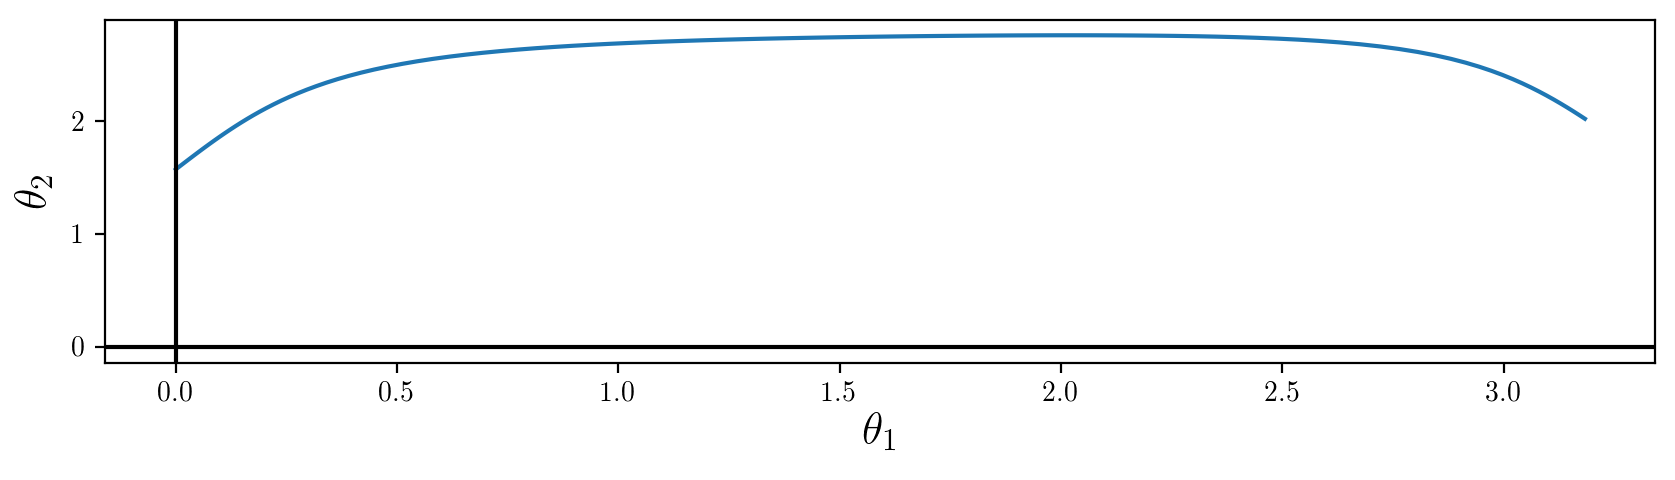

In [8]:
N  = 100
t0 = 0.0
tf = np.pi/2.0

x0 = np.array([0.0, np.pi/2.0])
p0 = np.array([0.2, 0.4])

tspan = list(np.linspace(t0, tf, N+1))

xf, pf = f(t0, x0, p0, tspan)
xf = np.array(xf)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(xf[:,0], xf[:,1])
ax1.set_xlabel(r'$\theta_1$', fontsize=16)
ax1.set_ylabel(r'$\theta_2$', fontsize=16)
ax1.axhline(0, color='k')
ax1.axvline(0, color='k')